<a href="https://colab.research.google.com/github/srilav/audioml/blob/master/M6_AST_04_Time_Series_Stationarity_ACF_Tests_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 4: Time Series Stationarity/ACF Tests

## Learning Objectives

At the end of the experiment, you will be able to

* check time series stationarity using Augmented-Dickey Fuller test
* check time series stationarity using Phillips Perron test
* use Kwiatkowski-Phillips-Schmidt-Shin test to check time series stationarity
* perform Ljung Box test to check autocorrelation

## Information

The regularity that may exist over time in the behavior of a time series, is known as **stationarity**.

For a time series to be stationary the following criterion is there:

* the mean of the series should not be a function of time, rather should be a constant.

* the variance of the series should not be a function of time.

* the covariance of the i th term and the (i + m) th term should not be a function of time.

There are tests to verify the stationarity of a time series. Some of them are described below:

* Augmented Dickey-Fuller test

* Phillips Perron test

* Kwiatkowski-Phillips-Schmidt-Shin test

Let's use these tests to check the stationarity of the seasonal Industrial production data.

### Setup Steps:

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2200183" #@param {type:"string"}

In [2]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "7671846954" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()
  
notebook= "M6_AST_04_Time_Series_Stationarity_ACF_Tests_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")  
    ipython.magic("sx pip -q install arch")
    ipython.magic("sx wget https://cdn.iisc.talentsprint.com/CDS/Datasets/electric_production.csv")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None
    
    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:        
        print(r["err"])
        return None   
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://cds.iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if not Additional: 
      raise NameError
    else:
      return Additional  
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None
  
  
# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None
  
def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None
  

def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError 
    else: 
      return Answer
  except NameError:
    print ("Please answer Question")
    return None
  

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup() 
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


### Import required packages

`statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests and statistical data exploration. 

[statsmodels.tsa](https://www.statsmodels.org/stable/tsa.html) contains model classes and functions that are useful for time series analysis.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

**Dataset Description**

The dataset is the Industrial production of electric and gas utilities in the United States, from the years 1985–2018. It contains monthly data starting from 1/1/1985 to 1/1/2018 having 12 entries per year.

This data measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [5]:
# Read dataset
df = pd.read_csv('electric_production.csv')
df.columns = ['Date','Production']
df.head()

,Date,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


Now to work with time series data, the 'date' column is converted into a datetime index.

In [6]:
# Convert Data column to datetime index
df['Date'] = pd.to_datetime(df['Date'])
df1 = df.set_index('Date')
df1.head()

,Production
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


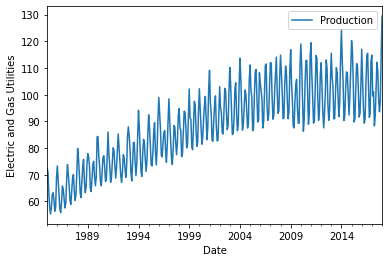

In [7]:
# Visualize data
df1.plot()
plt.ylabel("Electric and Gas Utilities")
plt.show()

As seen from the plot, this is seasonal data as there is some seasonality to it and an upward trend too. 

Now comparing the 12 month simple moving average along with the series to ascertain the trend. The standard deviation is also plotted to see if there is any variance or not.

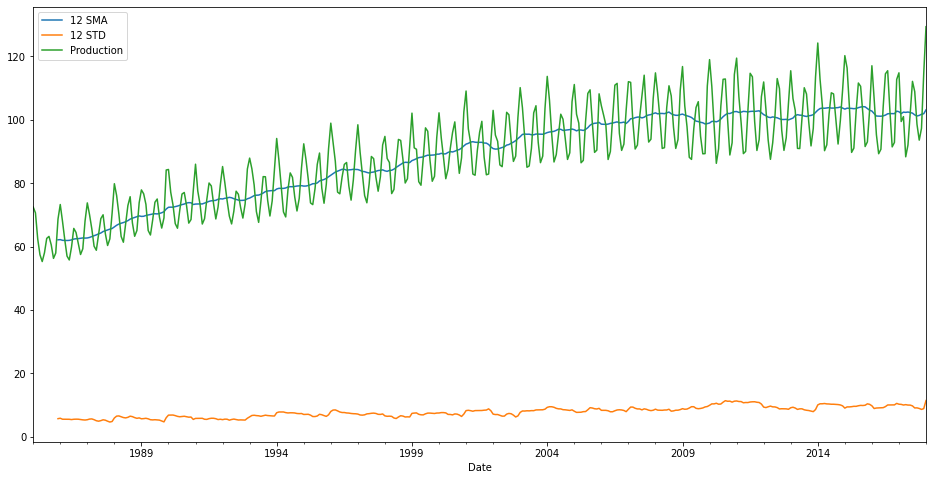

In [8]:
# 12 month simple moving average and standard deviation
df1['Production'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df1['Production'].rolling(12).std().plot(label='12 STD')
df1['Production'].plot()
plt.legend()

As seen from the above plot, the standard deviation is not varying much so there is not much variance.

**Decomposition of the time series data to its trend, seasonality and residual components.**

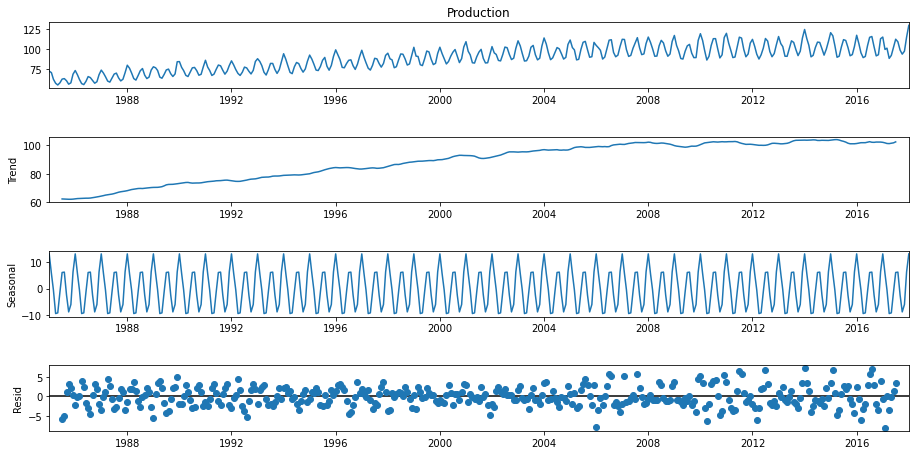

In [9]:
# Decompose time series
decomp = seasonal_decompose(df1['Production'])
fig = decomp.plot()
fig.set_size_inches(14,7)

The trend, seasonal and residual errors can be seen individually here.

### Check the data stationarity using Augmented Dickey-Fuller test

The **Augmented Dickey-Fuller test** is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller is one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise, a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Let's use the Augmented Dickey-Fuller test to check the stationarity of the seasonal Industrial production data.

From the statsmodels package, the Augmented Dickey-Fuller test function is used. It returns a tuple which consists of the values: adf, pvalue, usedlag, nobs, critical values, icbest and resstore.

In [10]:
# Applying ADF test
fuller_test = adfuller(df1['Production'])
fuller_test   

(-2.2569903500472366,
 0.18621469116587053,
 15,
 381,
 {'1%': -3.4476305904172904,
  '10%': -2.570827146203181,
  '5%': -2.869155980820355},
 1840.8474501627156)

Now the p-value is printed and using the p-value, it is ascertained if data is stationary or not.

In [11]:
def test_p_value(data):
    """ Return Data is stationary if p-value <= 0.05 """

    fuller_test = adfuller(data)
    print('P-value: ',fuller_test[1])
    if fuller_test[1] <= 0.05:
        print('Reject null hypothesis, data is stationary')
    else:
        print('Do not reject null hypothesis, data is not stationary')

# ADF test for Production series
test_p_value(df1['Production'])

P-value:  0.18621469116587053
Do not reject null hypothesis, data is not stationary


Since the data is not stationary, differencing is carried out. The difference is the change of the time series from one period to next. The first difference, second difference and seasonal difference are calculated and for each, the p-value is checked.

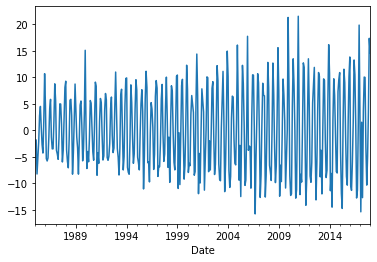

In [12]:
# Perform First order differencing
df1['First_diff'] = df1['Production'] - df1['Production'].shift(1)
df1['First_diff'].plot()

In [13]:
# ADF test for First order difference
test_p_value(df1['First_diff'].dropna())

P-value:  4.0777865655394705e-10
Reject null hypothesis, data is stationary


In the first difference, we got the data in stationary form. In case, a second difference was needed we apply differencing one more time.

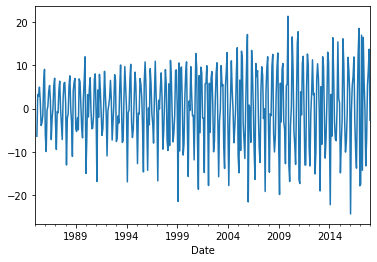

In [14]:
# Perform Second order differencing
df1['Second_diff'] = df1['First_diff'] - df1['First_diff'].shift(1)
df1['Second_diff'].plot()

In [15]:
# ADF test for Second order difference
test_p_value(df1['Second_diff'].dropna())

P-value:  4.1836937479977153e-17
Reject null hypothesis, data is stationary


A seasonal difference can also be taken as follows. The shifting will happen by an entire season that is '12'.

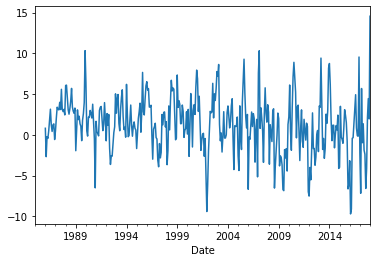

In [16]:
# Perform Seasonal differencing
df1['Seasonal_diff'] = df1['Production'] - df1['Production'].shift(12)
df1['Seasonal_diff'].plot()

In [17]:
# ADF test for Seasonal difference
test_p_value(df1['Seasonal_diff'].dropna())

P-value:  8.812644938088942e-07
Reject null hypothesis, data is stationary


### Check the data stationarity using Phillips Perron test

The Phillips-Perron test is similar to the ADF except that the regression run does not include lagged values of the first differences. Instead, the PP test fixes the t-statistic using a long run variance estimation, implemented using a Newey-West covariance estimator.

The null hypothesis of the Phillips-Perron (PP) test is that there is a unit root (series is not stationary), with the alternative that there is no unit root (series is stationary). If the p-value is above a critical size, then the null cannot be rejected and the series appears to be non-stationary.

In [18]:
# Applying PP test for Production series
pp = PhillipsPerron(df1['Production'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.552
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


From the above results, we can see that p-value is smaller than 0.05. So we reject the null hypothesis and the series is weakly stationary.

Now applying PP test to first order differencing series.

In [19]:
# Applying PP test for First_difference series
pp = PhillipsPerron(df1['First_diff'].dropna())
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -19.737
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


From the above results, we can see that p-value is smaller than 0.05. So we reject the null hypothesis and the series is weakly stationary.

Now applying PP test to second order differencing series.

In [20]:
# Applying PP test for Second_difference series
pp = PhillipsPerron(df1['Second_diff'].dropna())
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.171
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


From the above results, we can see that p-value is smaller than 0.05. So we reject the null hypothesis and the series is weakly stationary.

Now applying PP test to seasonal differencing series.

In [ ]:
# Applying PP test for Seasonal difference series
pp = PhillipsPerron(df1['Seasonal_diff'].dropna())
print(pp.summary().as_text())

From the above results, we can see that p-value is smaller than 0.05. So we reject the null hypothesis and the series is weakly stationary.

### Check the data stationarity using Kwiatkowski-Phillips-Schmidt-Shin test

The KPSS test is another quite commonly used test for stationarity. A very important point to note here is that the interpretation of KPSS is entirely opposite of the ADF test, and hence these tests cannot be used interchangeably. One needs to be very careful while interpreting these tests. 

KPSS test tests the below hypothesis:

* Null Hypothesis, H0: The time series is stationary.

* Alternative Hypothesis, H1: The time series is not stationary.

We can use the `kpss` method from the `statsmodels` library to perform this test and compare the value of the test statistics or the p-value. Since the hypothesis is the opposite of the ADF test, the interpretation of the p-value is also opposite.

* If the p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, we reject H0 and conclude that the time series is not stationary.

* If the p-value is greater than 0.05 or the absolute value of the test statistics is less than the critical value, we fail to reject H0 and conclude that the time series is stationary.

In [21]:
# Applying KPSS test for Production series
result = kpss(df1['Production'])
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(3.5315970094994853, 0.01, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 3.53
5% Critical Value: 0.46
p-value: 0.01


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


As we can see, the p-value is less than 0.05. We reject the null hypothesis and conclude that the time series is not stationary. This is consistent with the result obtained with the ADF test.

Now applying KPSS test to first order differencing series.

In [22]:
# Applying KPSS test for First_difference series
result = kpss(df1['First_diff'].dropna())
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.14518934657460816, 0.1, 34, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.15
5% Critical Value: 0.46
p-value: 0.10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


As we can see, the p-value is greater than 0.05. We fail to reject the null hypothesis and conclude that the time series is stationary. This is also consistent with the result obtained with the ADF test.

Now applying KPSS test to second order differencing series.

In [23]:
# Applying KPSS test for Second_difference series
result = kpss(df1['Second_diff'].dropna())
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.04529288943104178, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.05
5% Critical Value: 0.46
p-value: 0.10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


As we can see, the p-value is greater than 0.05. We fail to reject the null hypothesis and conclude that the time series is stationary.

Now applying KPSS test to seasonal order differencing series.

In [24]:
# Applying KPSS test for Seasonal_difference series
result = kpss(df1['Seasonal_diff'].dropna())
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.5811980172941592, 0.024345634791440068, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.58
5% Critical Value: 0.46
p-value: 0.02


As we can see, the p-value is less than 0.05. We reject the null hypothesis and conclude that the time series is not stationary. 

To know more about stationarity and tests related to it, click [here](https://blog.quantinsti.com/stationarity/).

### Ljung Box Test to check Autocorrelation

The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.

It uses the following hypotheses:

* H0: The data are independently distributed.

* HA: The data are not independently distributed; they exhibit serial correlation.

Ideally, we would like to fail to reject the null hypothesis. That is, we would like to see the p-value of the test be greater than 0.05 because this means the residuals for our time series model are independent, which is often an assumption we make when creating a model.

To perform the Ljung-Box test on a data series in Python, we can use the `acorr_ljungbox()` function from the statsmodels library which uses the following syntax:

**acorr_ljungbox(x, lags=None)**

where:

* **x:** The data series
* **lags:** Number of lags to test

This function returns a test statistic and a corresponding p-value. If the p-value is less than some threshold (e.g. α = .05), we can reject the null hypothesis and conclude that the residuals are not independently distributed.

In [25]:
# Perform Ljung-Box test on Production series with lag=5

test_stats, p = sm.stats.acorr_ljungbox(df['Production'], lags = [5])
print("Test statistic: ", test_stats)
print("p-value: ", p)

Test statistic:  lb_stat
p-value:  lb_pvalue


From the above results, we can see that the p-value of the test is much less than 0.05. Thus, **we reject the null hypothesis** of the test and conclude that the series values are **not independent** i.e., autocorrelation exists.

Note that we chose to use a lag value of 5 in this example, but we can choose any value we like to use for the lag.

### Please answer the questions below to complete the experiment:




In [28]:
#@title Select the False statement: { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "Null hypothesis for Ljung Box test is the data are not independently distributed and they exhibit serial correlation" #@param ["", "Null hypothesis for Augmented Dickey-Fuller test suggests the time series is non-stationary", "Null hypothesis for Ljung Box test is the data are not independently distributed and they exhibit serial correlation", "Alternate hypothesis for Phillips Perron test suggests the time series does not have a unit root, meaning it is stationary"]

In [33]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [29]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "There are two false statements.  Ljung H0- there are independently distributed. KPPS - H1: The time series is not stationary." #@param {type:"string"}


In [30]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [31]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [35]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [36]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 7477
Date of submission:  12 Mar 2022
Time of submission:  20:47:49
View your submissions: https://cds.iisc.talentsprint.com/notebook_submissions
